シード値 42 が設定されました。
計算に cpu を使用します。
クラス数: 8
クラス名: ['Africa', 'Asia', 'Europe', 'Japan', 'Middle East', 'North America', 'Oceania', 'South America']

ResNet-18モデルをロードしています...


/Users/nakasoneasahi/.venv/info3dm/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/nakasoneasahi/.venv/info3dm/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



学習を開始します...
Epoch [1/10], Average Training Loss: 1.9369
Epoch [1/10], Test Accuracy: 36.70%
Epoch [2/10], Average Training Loss: 1.6308
Epoch [2/10], Test Accuracy: 41.51%
Epoch [3/10], Average Training Loss: 1.4804
Epoch [3/10], Test Accuracy: 43.11%
Epoch [4/10], Average Training Loss: 1.3418
Epoch [4/10], Test Accuracy: 49.17%
Epoch [5/10], Average Training Loss: 1.1194
Epoch [5/10], Test Accuracy: 45.43%
Epoch [6/10], Average Training Loss: 0.9263
Epoch [6/10], Test Accuracy: 52.91%
Epoch [7/10], Average Training Loss: 0.7350
Epoch [7/10], Test Accuracy: 49.23%
Epoch [8/10], Average Training Loss: 0.5473
Epoch [8/10], Test Accuracy: 54.33%
Epoch [9/10], Average Training Loss: 0.4171
Epoch [9/10], Test Accuracy: 50.12%
Epoch [10/10], Average Training Loss: 0.3352
Epoch [10/10], Test Accuracy: 53.62%
学習が完了しました。

--- テスト結果の詳細 ---

--- 全体の予測結果 ---
総サンプル数: 1684
正解数: 903
全体正答率: 53.62%

--- クラス別予測結果 ---
クラス名                 | 正解数        | 総数         | 正答率       
---------------------+---

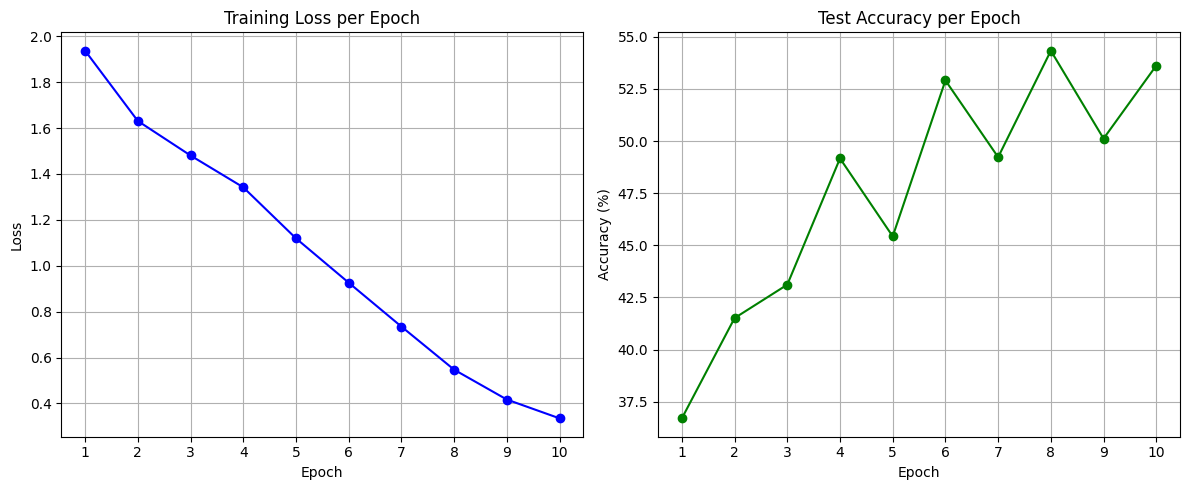

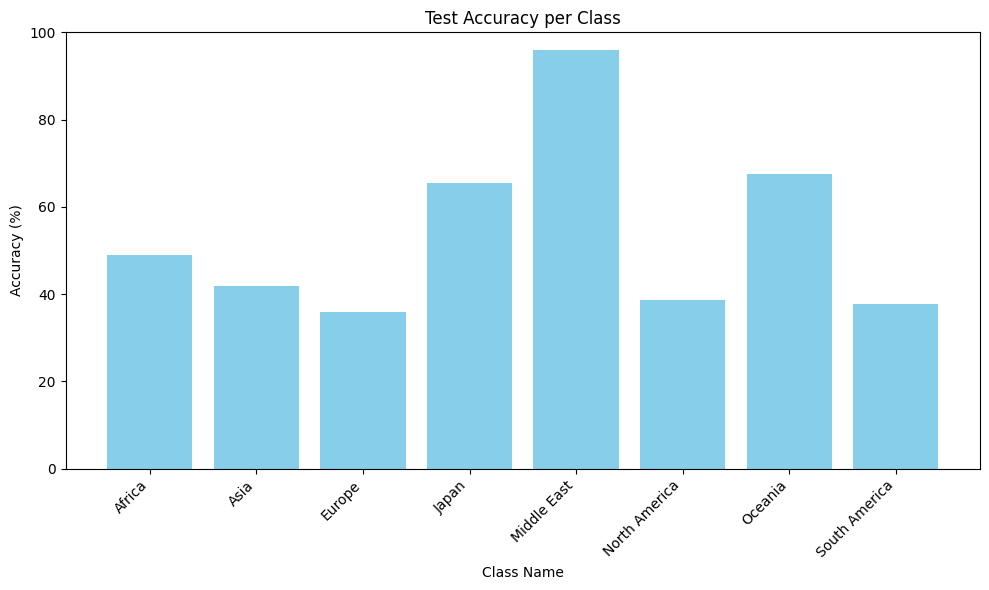


--- 混同行列のヒートマップ ---


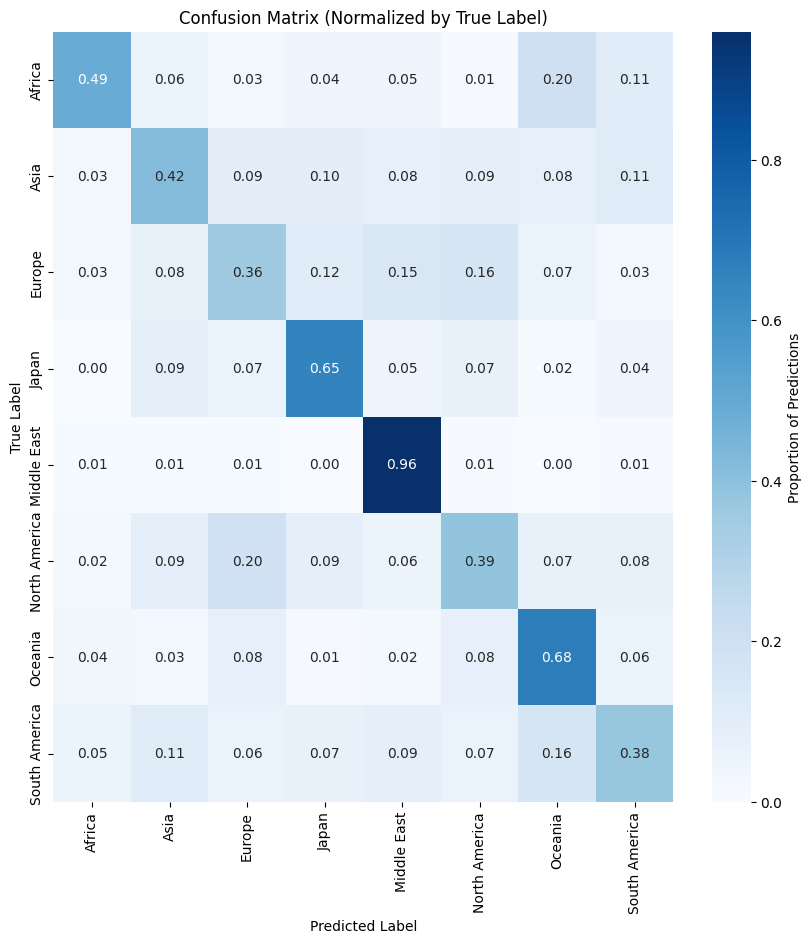

In [1]:
import torch
import os
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models # models をインポート
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# シード値の設定
seed_value = 42
torch.manual_seed(seed_value)
np.random.seed(seed_value)
print(f"シード値 {seed_value} が設定されました。")

# デバイスの設定 (GPUが利用可能ならGPU、なければCPUを使用)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"計算に {device} を使用します。")

# データセットのルートディレクトリ
# このパスはあなたのローカル環境に合わせてください。
data_dir = '/Users/nakasoneasahi/info3dm/geoguesser/split_dataset'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

# --- ▼▼▼ 画像の前処理 ▼▼▼ ---
# ResNetは通常224x224で学習されているため、サイズを合わせると性能が向上する可能性があります。
# ここでは元の64x64のままにしますが、224x224に変更して試すことを推奨します。
IMAGE_SIZE = 64 # または 224

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    # この正規化パラメータはImageNet学習時の標準値であり、転移学習で推奨されます
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# --- ▲▲▲ 画像の前処理 ▲▲▲ ---


# データローダーの作成
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# クラス数の取得
num_classes = len(train_dataset.classes)
class_names = train_dataset.classes
print(f"クラス数: {num_classes}")
print(f"クラス名: {class_names}")

# --- ▼▼▼ モデル定義の変更 ▼▼▼ ---
# SimpleCNNの代わりに、事前学習済みのResNet-18をロードします
print("\nResNet-18モデルをロードしています...")

# 1. ImageNetで学習済みのResNet-18をロード
model = models.resnet18(pretrained=True)

# 2. ResNetの最後の全結合層(fc)を、我々のデータセットのクラス数に合わせて新しい層に置き換える
num_ftrs = model.fc.in_features  # 元のモデルの最終層の入力次元数を取得
model.fc = nn.Linear(num_ftrs, num_classes) # 新しい全結合層に付け替え

model = model.to(device) # モデルをデバイスに送る
# --- ▲▲▲ モデル定義の変更 ▲▲▲ ---

# 損失関数と最適化関数の定義
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 学習の履歴を保存するためのリスト
train_losses = []
test_accuracies = []

# 学習
num_epochs = 10
print("\n学習を開始します...")
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # 各エポックの平均損失を記録
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Training Loss: {epoch_loss:.4f}')

    # テスト (学習中の進捗確認)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Test Accuracy: {accuracy:.2f}%')

print('学習が完了しました。')

# --- ここから下のテスト結果の集計とプロット生成のコードは変更ありません ---

print("\n--- テスト結果の詳細 ---")
model.eval()

all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

total_samples = len(all_labels)
correct_predictions = sum(np.array(all_predictions) == np.array(all_labels))

print(f"\n--- 全体の予測結果 ---")
print(f"総サンプル数: {total_samples}")
print(f"正解数: {correct_predictions}")
print(f"全体正答率: {(correct_predictions / total_samples * 100):.2f}%")

print(f"\n--- クラス別予測結果 ---")
class_correct = {i: 0 for i in range(num_classes)}
class_total = {i: 0 for i in range(num_classes)}
for i in range(total_samples):
    true_label = all_labels[i]
    pred_label = all_predictions[i]
    class_total[true_label] += 1
    if true_label == pred_label:
        class_correct[true_label] += 1

class_accuracies = []
print(f"{'クラス名':<20} | {'正解数':<10} | {'総数':<10} | {'正答率':<10}")
print(f"{'-'*20}-+-{'-'*10}-+-{'-'*10}-+-{'-'*10}")
for i in range(num_classes):
    class_name = class_names[i]
    correct_count = class_correct[i]
    total_count = class_total[i]
    class_accuracy = (correct_count / total_count) * 100 if total_count > 0 else 0
    class_accuracies.append(class_accuracy)
    print(f"{class_name:<20} | {correct_count:<10} | {total_count:<10} | {class_accuracy:.2f}%")

# --- プロット生成コード ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-', color='blue')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.xticks(range(1, num_epochs + 1))

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), test_accuracies, marker='o', linestyle='-', color='green')
plt.title('Test Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.xticks(range(1, num_epochs + 1))
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(class_names, class_accuracies, color='skyblue')
plt.xlabel('Class Name')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy per Class')
plt.ylim(0, 100)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\n--- 混同行列のヒートマップ ---")
cm = confusion_matrix(all_labels, all_predictions)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(num_classes + 2, num_classes + 2))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Proportion of Predictions'})
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Normalized by True Label)')
plt.show()

シード値 42 が設定されました。
計算に cpu を使用します。
クラス数: 8
クラス名: ['Africa', 'Asia', 'Europe', 'Japan', 'Middle East', 'North America', 'Oceania', 'South America']

ResNet-18モデルをロードしています...


/Users/nakasoneasahi/.venv/info3dm/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/nakasoneasahi/.venv/info3dm/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



学習を開始します...
Epoch [1/30], Average Training Loss: 1.7273
Epoch [1/30], Test Accuracy: 42.82%
Epoch [2/30], Average Training Loss: 1.4407
Epoch [2/30], Test Accuracy: 46.90%
Epoch [3/30], Average Training Loss: 1.2731
Epoch [3/30], Test Accuracy: 56.62%
Epoch [4/30], Average Training Loss: 1.1068
Epoch [4/30], Test Accuracy: 58.12%
Epoch [5/30], Average Training Loss: 0.9461
Epoch [5/30], Test Accuracy: 55.86%
Epoch [6/30], Average Training Loss: 0.7544
Epoch [6/30], Test Accuracy: 65.73%
Epoch [7/30], Average Training Loss: 0.5718
Epoch [7/30], Test Accuracy: 66.23%
Epoch [8/30], Average Training Loss: 0.4182
Epoch [8/30], Test Accuracy: 65.62%
Epoch [9/30], Average Training Loss: 0.3284
Epoch [9/30], Test Accuracy: 69.50%
Epoch [10/30], Average Training Loss: 0.2694
Epoch [10/30], Test Accuracy: 69.90%
Epoch [11/30], Average Training Loss: 0.2127
Epoch [11/30], Test Accuracy: 70.00%
Epoch [12/30], Average Training Loss: 0.1847
Epoch [12/30], Test Accuracy: 66.11%
Epoch [13/30], Averag

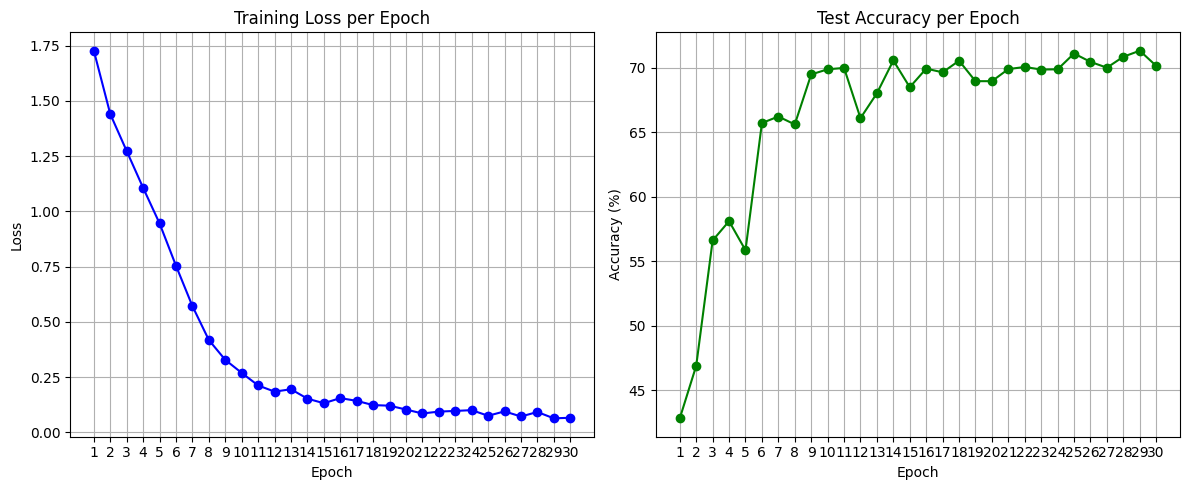

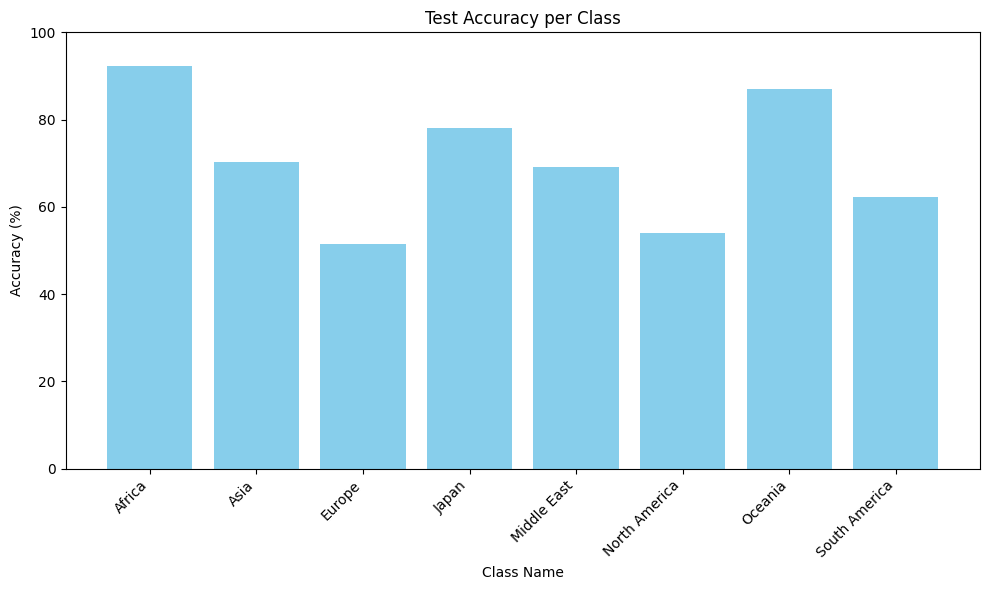


--- 混同行列のヒートマップ ---


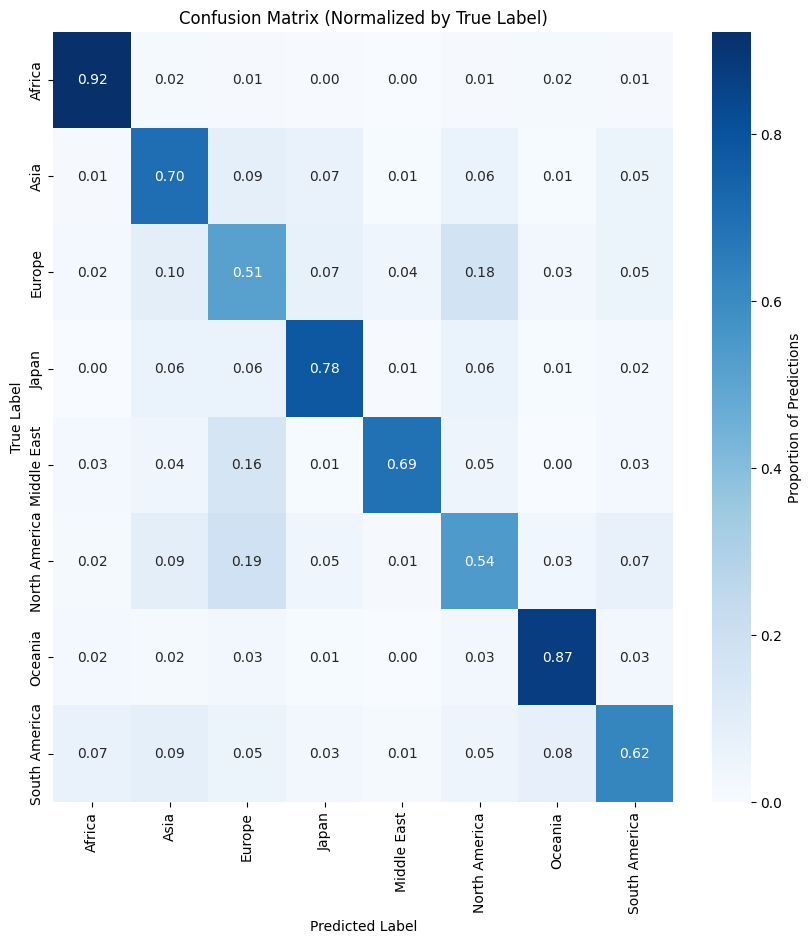

In [2]:
import torch
import os
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models # models をインポート
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# シード値の設定
seed_value = 42
torch.manual_seed(seed_value)
np.random.seed(seed_value)
print(f"シード値 {seed_value} が設定されました。")

# デバイスの設定 (GPUが利用可能ならGPU、なければCPUを使用)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"計算に {device} を使用します。")

# データセットのルートディレクトリ
# このパスはあなたのローカル環境に合わせてください。
data_dir = '/Users/nakasoneasahi/info3dm/geoguesser/split_dataset2'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

# --- ▼▼▼ 画像の前処理 ▼▼▼ ---
# ResNetは通常224x224で学習されているため、サイズを合わせると性能が向上する可能性があります。
# ここでは元の64x64のままにしますが、224x224に変更して試すことを推奨します。
IMAGE_SIZE = 64 # または 224

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    # この正規化パラメータはImageNet学習時の標準値であり、転移学習で推奨されます
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# --- ▲▲▲ 画像の前処理 ▲▲▲ ---


# データローダーの作成
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# クラス数の取得
num_classes = len(train_dataset.classes)
class_names = train_dataset.classes
print(f"クラス数: {num_classes}")
print(f"クラス名: {class_names}")

# --- ▼▼▼ モデル定義の変更 ▼▼▼ ---
# SimpleCNNの代わりに、事前学習済みのResNet-18をロードします
print("\nResNet-18モデルをロードしています...")

# 1. ImageNetで学習済みのResNet-18をロード
model = models.resnet18(pretrained=True)

# 2. ResNetの最後の全結合層(fc)を、我々のデータセットのクラス数に合わせて新しい層に置き換える
num_ftrs = model.fc.in_features  # 元のモデルの最終層の入力次元数を取得
model.fc = nn.Linear(num_ftrs, num_classes) # 新しい全結合層に付け替え

model = model.to(device) # モデルをデバイスに送る
# --- ▲▲▲ モデル定義の変更 ▲▲▲ ---

# 損失関数と最適化関数の定義
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 学習の履歴を保存するためのリスト
train_losses = []
test_accuracies = []

# 学習
num_epochs = 30
print("\n学習を開始します...")
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # 各エポックの平均損失を記録
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Training Loss: {epoch_loss:.4f}')

    # テスト (学習中の進捗確認)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Test Accuracy: {accuracy:.2f}%')

print('学習が完了しました。')

# --- ここから下のテスト結果の集計とプロット生成のコードは変更ありません ---

print("\n--- テスト結果の詳細 ---")
model.eval()

all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

total_samples = len(all_labels)
correct_predictions = sum(np.array(all_predictions) == np.array(all_labels))

print(f"\n--- 全体の予測結果 ---")
print(f"総サンプル数: {total_samples}")
print(f"正解数: {correct_predictions}")
print(f"全体正答率: {(correct_predictions / total_samples * 100):.2f}%")

print(f"\n--- クラス別予測結果 ---")
class_correct = {i: 0 for i in range(num_classes)}
class_total = {i: 0 for i in range(num_classes)}
for i in range(total_samples):
    true_label = all_labels[i]
    pred_label = all_predictions[i]
    class_total[true_label] += 1
    if true_label == pred_label:
        class_correct[true_label] += 1

class_accuracies = []
print(f"{'クラス名':<20} | {'正解数':<10} | {'総数':<10} | {'正答率':<10}")
print(f"{'-'*20}-+-{'-'*10}-+-{'-'*10}-+-{'-'*10}")
for i in range(num_classes):
    class_name = class_names[i]
    correct_count = class_correct[i]
    total_count = class_total[i]
    class_accuracy = (correct_count / total_count) * 100 if total_count > 0 else 0
    class_accuracies.append(class_accuracy)
    print(f"{class_name:<20} | {correct_count:<10} | {total_count:<10} | {class_accuracy:.2f}%")

# --- プロット生成コード ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-', color='blue')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.xticks(range(1, num_epochs + 1))

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), test_accuracies, marker='o', linestyle='-', color='green')
plt.title('Test Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.xticks(range(1, num_epochs + 1))
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(class_names, class_accuracies, color='skyblue')
plt.xlabel('Class Name')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy per Class')
plt.ylim(0, 100)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\n--- 混同行列のヒートマップ ---")
cm = confusion_matrix(all_labels, all_predictions)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(num_classes + 2, num_classes + 2))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Proportion of Predictions'})
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Normalized by True Label)')
plt.show()

シード値 42 が設定されました。
計算に cpu を使用します。
クラス数: 8
クラス名: ['Africa', 'Asia', 'Europe', 'Japan', 'Middle East', 'North America', 'Oceania', 'South America']

ResNet-50モデルをロードしています...

学習を開始します... (Epochs: 10)
Epoch [1/10], Loss: 1.6717, Test Accuracy: 42.46%, Duration: 1173.35s
Epoch [2/10], Loss: 1.4025, Test Accuracy: 50.38%, Duration: 1191.48s
Epoch [3/10], Loss: 1.2706, Test Accuracy: 53.90%, Duration: 1249.33s
Epoch [4/10], Loss: 1.1850, Test Accuracy: 51.64%, Duration: 1212.42s
Epoch [5/10], Loss: 1.1014, Test Accuracy: 58.98%, Duration: 1217.64s
Epoch [6/10], Loss: 1.0397, Test Accuracy: 60.86%, Duration: 7307.81s
Epoch [7/10], Loss: 0.9818, Test Accuracy: 61.08%, Duration: 1059.79s
Epoch [8/10], Loss: 0.9167, Test Accuracy: 59.99%, Duration: 1149.67s
Epoch [9/10], Loss: 0.8553, Test Accuracy: 62.88%, Duration: 1258.61s
Epoch [10/10], Loss: 0.7831, Test Accuracy: 67.01%, Duration: 1150.29s

学習が完了しました。総学習時間: 299.51 分

--- テスト結果の詳細 ---

--- 全体の予測結果 ---
総サンプル数: 5544
正解数: 3715
最終的な全体正答率: 67.01

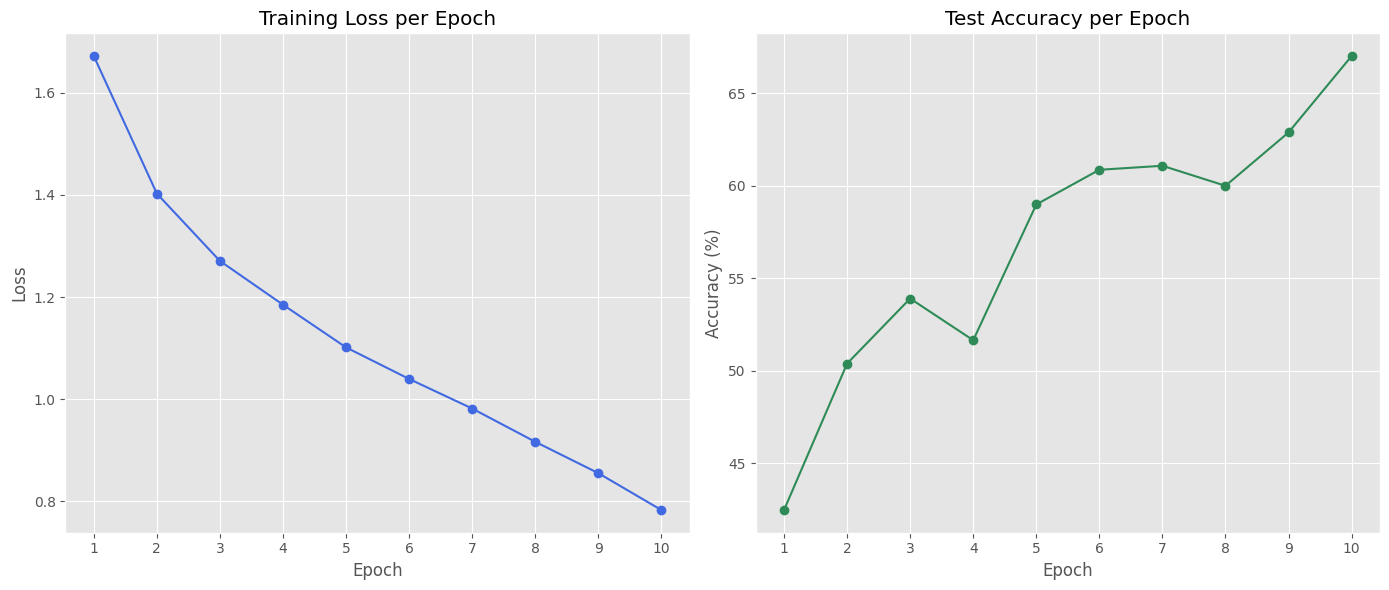

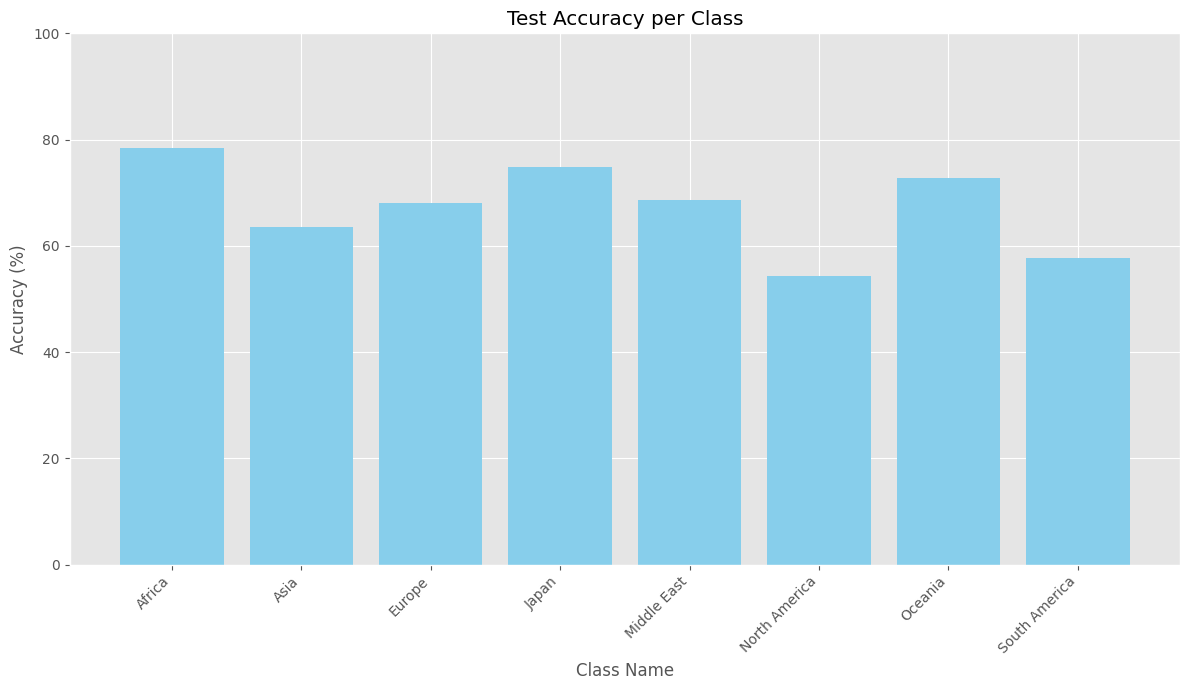


--- 混同行列のヒートマップ ---


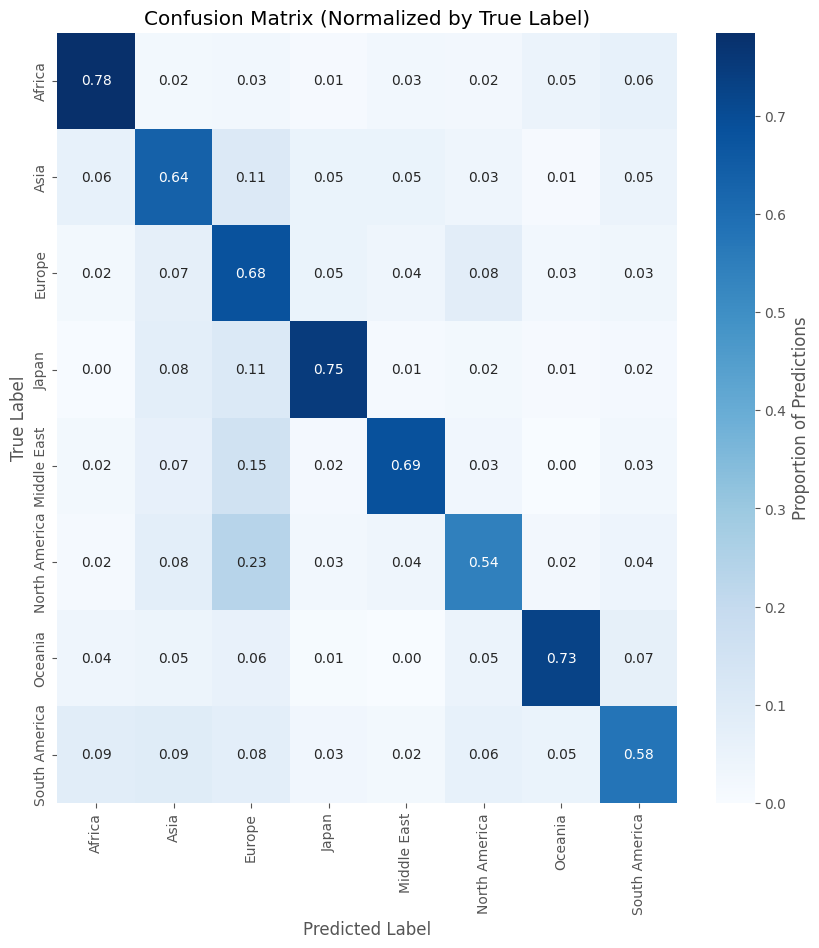

In [3]:
import torch
import os
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import time

# --- 基本設定 ---
# シード値の設定
seed_value = 42
torch.manual_seed(seed_value)
np.random.seed(seed_value)
print(f"シード値 {seed_value} が設定されました。")

# デバイスの設定 (GPUが利用可能ならGPU、なければCPUを使用)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"計算に {device} を使用します。")


# --- データセットと画像の前処理 ---
# ★★★ ご指定のパスに設定済み ★★★
data_dir = '/Users/nakasoneasahi/info3dm/geoguesser/split_dataset2'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

# ★★★ 性能向上のため画像サイズを224x224に変更 ★★★
IMAGE_SIZE = 64

# ★★★ 性能向上のためデータ拡張を追加 ★★★
# 学習用データには回転や反転を適用し、モデルの汎化性能を向上させる
transform_train = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(), # 50%の確率で左右反転
    transforms.RandomRotation(15),     # -15度から+15度の範囲でランダムに回転
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# テスト用データにはデータ拡張を適用しない（評価の公平性を保つため）
transform_test = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# データローダーの作成
train_dataset = datasets.ImageFolder(train_dir, transform=transform_train)
test_dataset = datasets.ImageFolder(test_dir, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# クラス情報の取得
num_classes = len(train_dataset.classes)
class_names = train_dataset.classes
print(f"クラス数: {num_classes}")
print(f"クラス名: {class_names}")


# --- ★★★ モデルをResNet-50に変更 ★★★ ---
print("\nResNet-50モデルをロードしています...")

# 1. ImageNetで学習済みのResNet-50をロード
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# 2. ResNetの最後の全結合層(fc)を、我々のデータセットのクラス数に合わせて新しい層に置き換える
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

model = model.to(device) # モデルをデバイスに送る


# 損失関数と最適化関数の定義
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 学習の履歴を保存するためのリスト
train_losses = []
test_accuracies = []


# --- ★★★ 学習ループ (30エポック) ★★★ ---
num_epochs = 10
print(f"\n学習を開始します... (Epochs: {num_epochs})")
start_time = time.time()

for epoch in range(num_epochs):
    epoch_start_time = time.time()
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # 各エポックの平均損失を記録
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    # テスト (学習中の進捗確認)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)
    
    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Test Accuracy: {accuracy:.2f}%, Duration: {epoch_duration:.2f}s')

end_time = time.time()
total_training_time = end_time - start_time
print(f'\n学習が完了しました。総学習時間: {total_training_time / 60:.2f} 分')


# --- テスト結果の詳細な集計とプロット生成 (変更なし) ---
print("\n--- テスト結果の詳細 ---")
model.eval()

all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

total_samples = len(all_labels)
correct_predictions = sum(np.array(all_predictions) == np.array(all_labels))

print(f"\n--- 全体の予測結果 ---")
print(f"総サンプル数: {total_samples}")
print(f"正解数: {correct_predictions}")
print(f"最終的な全体正答率: {(correct_predictions / total_samples * 100):.2f}%")

print(f"\n--- クラス別予測結果 ---")
class_correct = {i: 0 for i in range(num_classes)}
class_total = {i: 0 for i in range(num_classes)}
for i in range(total_samples):
    true_label = all_labels[i]
    pred_label = all_predictions[i]
    class_total[true_label] += 1
    if true_label == pred_label:
        class_correct[true_label] += 1

class_accuracies = []
print(f"{'クラス名':<20} | {'正解数':<10} | {'総数':<10} | {'正答率':<10}")
print(f"{'-'*20}-+-{'-'*10}-+-{'-'*10}-+-{'-'*10}")
for i in range(num_classes):
    class_name = class_names[i]
    correct_count = class_correct[i]
    total_count = class_total[i]
    class_accuracy = (correct_count / total_count) * 100 if total_count > 0 else 0
    class_accuracies.append(class_accuracy)
    print(f"{class_name:<20} | {correct_count:<10} | {total_count:<10} | {class_accuracy:.2f}%")

# --- プロット生成 (変更なし) ---
plt.style.use('ggplot')

# 学習曲線（損失と正答率）
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-', color='royalblue')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.xticks(range(1, num_epochs + 1))

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), test_accuracies, marker='o', linestyle='-', color='seagreen')
plt.title('Test Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.xticks(range(1, num_epochs + 1))
plt.tight_layout()
plt.show()

# クラス別正答率の棒グラフ
plt.figure(figsize=(12, 7))
plt.bar(class_names, class_accuracies, color='skyblue')
plt.xlabel('Class Name')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy per Class')
plt.ylim(0, 100)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 混同行列のヒートマップ
print("\n--- 混同行列のヒートマップ ---")
cm = confusion_matrix(all_labels, all_predictions)
#
cm_normalized = np.nan_to_num(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])
plt.figure(figsize=(num_classes + 2, num_classes + 2))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Proportion of Predictions'})
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Normalized by True Label)')
plt.show()